In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Imports

In [16]:
from pytorch_eo.datasets import SEN12Floods
from pytorch_eo.datasets.sensors import Sensors, S1, S2

import lightning as L
from sklearn.metrics import average_precision_score
import albumentations as A
from pytorch_eo.tasks.classification import ImageClassification
import timm
import torch

# SEN12-FLOODS

In this example we are going to train 2 image classifiers using the [SEN12-FLOODS](https://mlhub.earth/data/sen12floods) dataset. `SEN12-FLOOD` is a set of multimodal (SAR + multispectral) satellite image time-series for flood classification. The observed areas correspond to 337 locations (cities and their surroundings ) in West and SouthEast Africa, Middle-East, and Australia where a flood event occurred during the considered period. The period of acquisition goes from December 2018 to May 2019.

For each location, the following data are provided:
- Time series of Sentinel-2 multispectral images. These images are composed of 12 bands,
at 10m ground-sampling distance and are provided with Level 2A atmospheric correction.
- Time series of Sentinel-1 Synthetic Aperture Radar (SAR) images. The images are provided
with radiometric calibration and range doppler terrain correction based on the SRTM digital
elevation model. For one acquisition, two raster images are available corresponding to the
polarimetry channels VV and VH.
- Time series of binary labels for each image / date: flood or no flood.
The original dataset was split into 262 sequences for the train and 68 sequences for the test.

As said, we are going to traing 2 image classifiers using different sensors:

1. Using S1 images.
2. Using S2 images.

This dataset needs to be downloaded from the [SEN12-FLOOD Radian MLHUB](https://mlhub.earth/data/sen12floods) website before training the models. Once downloaded you will need a folder with the following structure:

- sen12floods_s1_labels.
- sen12floods_s1_source.
- sen12floods_s2_labels.
- sen12floods_s2_source.

Then you can instantiate the Dataset as follows, selecting the sensors and bands that you want to work with.

## Sentinel-1

First of all, let's train a image classifier using images from Sentinel-1.

In [17]:
# Resizing the images to 64x64 to plot them
trans = A.Compose([
    A.Resize(64,64)                           
])

ds = SEN12Floods(processed_data_path='datasets/sen12floods',
                 batch_size=25,
                 verbose=True, 
                 sensor=Sensors.S1,
                 bands=[S1.VH, S1.VV], 
                 train_trans=trans,
                ) 

ds.setup()

Number of images: 3331
Training samples 1999
Validation samples 666
Test samples 666


All out datasets have a `DataFrame` containing the required data to train the model. In this case, the list of images and labels. Use this object to explore the dataset.

In [18]:
ds.df

,image,label
0,/Users/fran/Documents/datasets/sen12floods/sen...,0
1,/Users/fran/Documents/datasets/sen12floods/sen...,0
2,/Users/fran/Documents/datasets/sen12floods/sen...,0
3,/Users/fran/Documents/datasets/sen12floods/sen...,0
4,/Users/fran/Documents/datasets/sen12floods/sen...,1
...,...,...
3326,/Users/fran/Documents/datasets/sen12floods/sen...,0
3327,/Users/fran/Documents/datasets/sen12floods/sen...,0
3328,/Users/fran/Documents/datasets/sen12floods/sen...,0
3329,/Users/fran/Documents/datasets/sen12floods/sen...,0


In [19]:
ds.num_classes, ds.classes

(2, ['NO_FLOODING', 'FLOODING'])

Let's visualize some samples from the dataset. You can extract data from the `Dataset`s objects or the `DataLoaders`. `PytorchEO` is designed to work with arbitrary number of inputs and outputs, so we use a `dict` to name the different tensors.

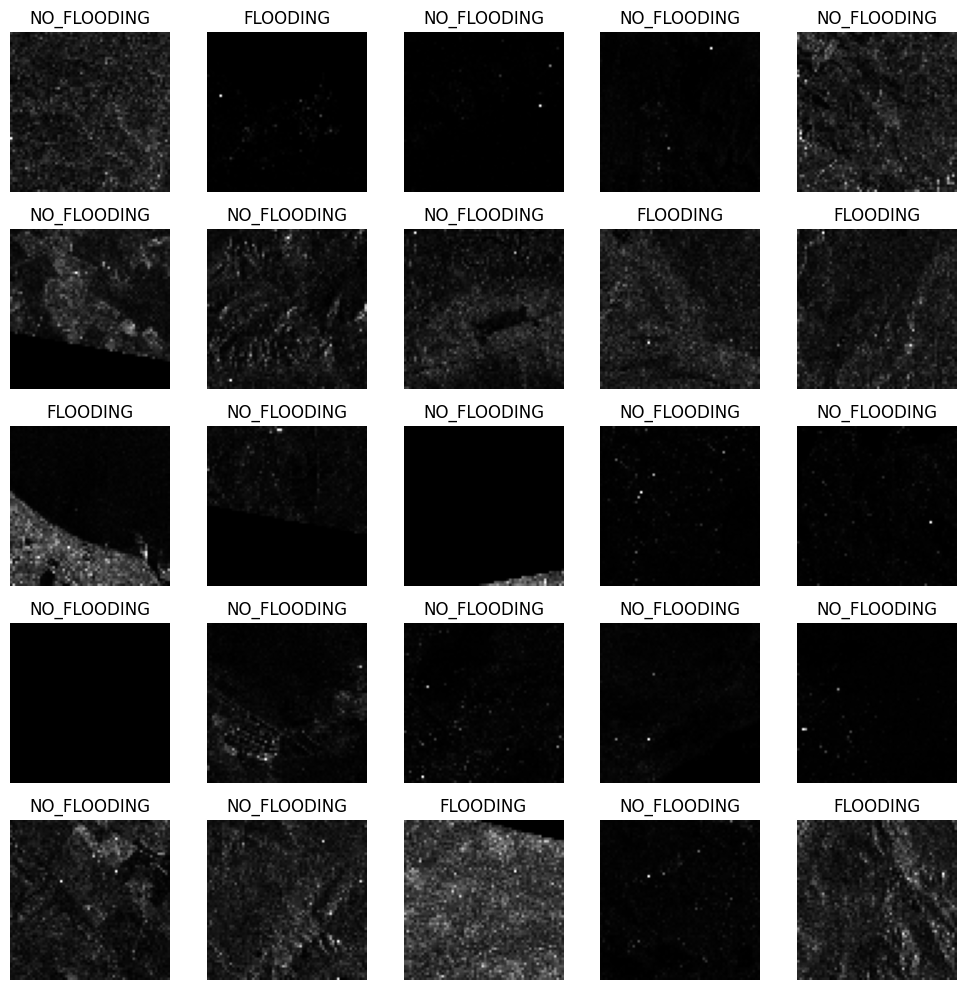

In [20]:
import matplotlib.pyplot as plt

batch = next(iter(ds.train_dataloader()))
imgs, labels = batch['image'], batch['label']

fig = plt.figure(figsize=(10, 10))
for i, (img, label) in enumerate(zip(imgs, labels)):
    ax = plt.subplot(5, 5, i + 1)
    if img.ndim == 2:
        ax.imshow(img, cmap="gray") # one band 
    else:
        ax.imshow(img[...,0], cmap="gray") # first band
    ax.set_title(ds.classes[label.item()])
    ax.axis('off')
plt.tight_layout()
plt.show()

Let's train our model! 

In [21]:
ds = SEN12Floods(processed_data_path='datasets/sen12floods',
                 batch_size=64,
                 verbose=True, 
                 sensor=Sensors.S1,
                 bands=[S1.VH, S1.VV],
                 pin_memory=True,
                ) 

ds.setup()

model = timm.create_model('resnet18', pretrained=True, num_classes=ds.num_classes, in_chans=ds.num_bands)

hparams = {
    'optimizer': 'Adam',
    'optim_params': {
        'lr': 1e-4,
    }
}

def my_map(y_hat, y):
    return average_precision_score(y.cpu(), torch.sigmoid(y_hat).detach().cpu(), average='micro')

task = ImageClassification(num_classes=ds.num_classes , model=model, hparams=hparams)

trainer = L.Trainer(
    accelerator='cpu',
    devices=1,
    max_epochs=3,
)

trainer.fit(task, ds)

Number of images: 3331
Training samples 1999
Validation samples 666
Test samples 666


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/fran/Documents/Projects/pytorchEO/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name    | Type               | Params
-----------------------------------------------
0 | model   | ResNet             | 11.2 M
1 | loss_fn | CrossEntropyLoss   | 0     
2 | acc     | MulticlassAccuracy | 0     
-----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.698    Total estimated model params size (MB)


Number of images: 3331
Training samples 1999
Validation samples 666
Test samples 666
Sanity Checking: 0it [00:00, ?it/s]

/Users/fran/Documents/Projects/pytorchEO/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/fran/Documents/Projects/pytorchEO/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/fran/Documents/Projects/pytorchEO/.venv/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 2: 100%|██████████| 32/32 [15:36<00:00, 29.27s/it, v_num=42, loss=0.389, acc=0.800, val_loss=0.643, val_acc=0.691]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 32/32 [15:36<00:00, 29.27s/it, v_num=42, loss=0.389, acc=0.800, val_loss=0.643, val_acc=0.691]


In [22]:
trainer.test(dataloaders=ds.test_dataloader())

/Users/fran/Documents/Projects/pytorchEO/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:148: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at /Users/fran/Documents/Projects/pytorchEO/examples/lightning_logs/version_42/checkpoints/epoch=2-step=96.ckpt
Loaded model weights from the checkpoint at /Users/fran/Documents/Projects/pytorchEO/examples/lightning_logs/version_42/checkpoints/epoch=2-step=96.ckpt
/Users/fran/Documents/Projects/pytorchEO/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Con

Number of images: 3331
Training samples 1999
Validation samples 666
Test samples 666
Testing DataLoader 0: 100%|██████████| 11/11 [01:37<00:00,  8.82s/it]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6906906962394714     │
│         test_loss         │    0.6416068077087402     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6416068077087402, 'test_acc': 0.6906906962394714}]

It looks good!

## Sentinel-2

Now, we can train a model using Sentinel-2 imagery.

In [23]:
ds = SEN12Floods(processed_data_path='datasets/sen12floods',
                 batch_size=25,
                 verbose=True, 
                 sensor=Sensors.S2,
                 bands=[S2.RGB], 
                ) 

ds.setup()

Number of images: 2236
Training samples 1342
Validation samples 447
Test samples 447


As showed before, all out datasets have a `DataFrame` containing the required data to train the model.

In [24]:
ds.df

,image,label
0,/Users/fran/Documents/datasets/sen12floods/sen...,0
1,/Users/fran/Documents/datasets/sen12floods/sen...,0
2,/Users/fran/Documents/datasets/sen12floods/sen...,1
3,/Users/fran/Documents/datasets/sen12floods/sen...,1
4,/Users/fran/Documents/datasets/sen12floods/sen...,0
...,...,...
2231,/Users/fran/Documents/datasets/sen12floods/sen...,0
2232,/Users/fran/Documents/datasets/sen12floods/sen...,0
2233,/Users/fran/Documents/datasets/sen12floods/sen...,0
2234,/Users/fran/Documents/datasets/sen12floods/sen...,0


In [25]:
ds.num_classes, ds.classes

(2, ['NO_FLOODING', 'FLOODING'])

Let's visualize some samples from the dataset. 

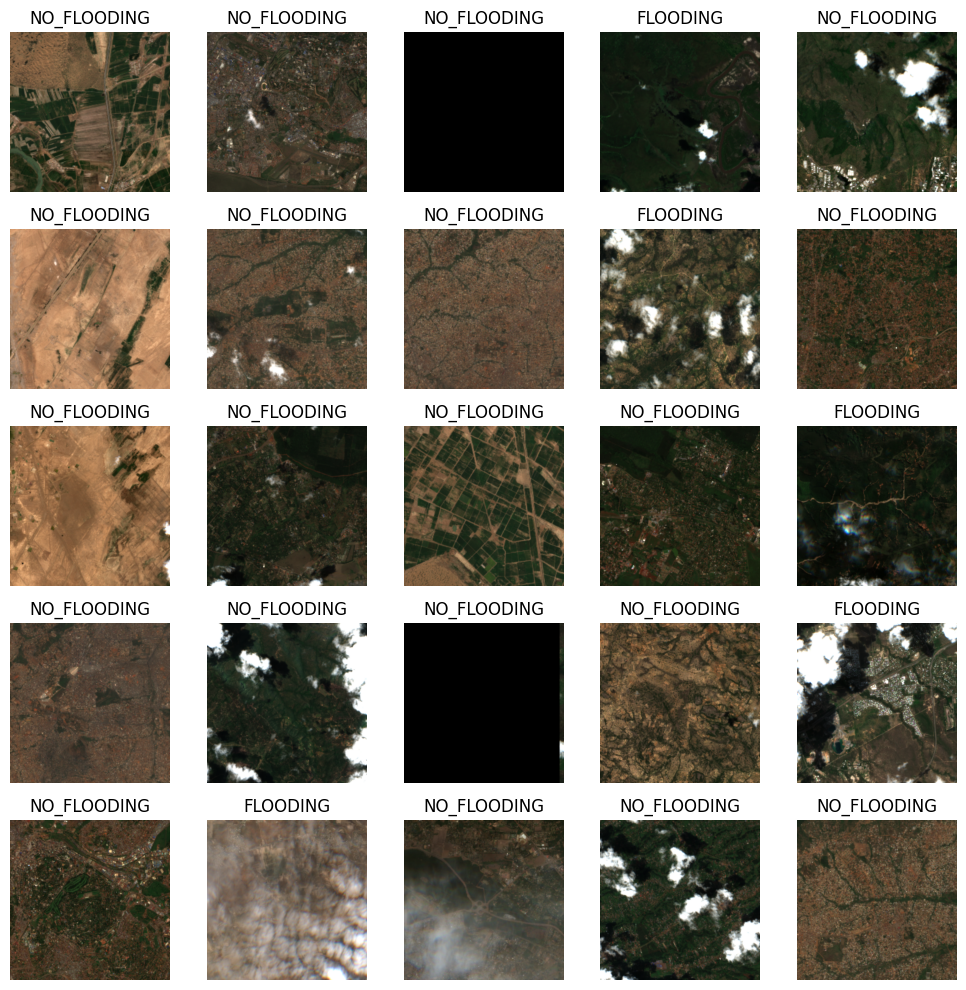

In [26]:
import matplotlib.pyplot as plt

# extract a batch of samples (you can also access val_dataloader or test_dataloader for the other splits)

batch = next(iter(ds.train_dataloader()))
imgs, labels = batch['image'], batch['label']

fig = plt.figure(figsize=(10, 10))
for i, (img, label) in enumerate(zip(imgs, labels)):
    ax = plt.subplot(5, 5, i + 1)
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(ds.classes[label.item()])
    ax.axis('off')
plt.tight_layout()
plt.show()

Let's train an image classifier on this dataset. To do so, we need to define a `task`. In this case, we use the `ImageClassification` task.

In [27]:
import torch 
from pytorch_eo.tasks.classification import ImageClassification

task = ImageClassification(num_classes=ds.num_classes)

output = task(torch.randn(8, 3, 224, 224))
output.shape

torch.Size([8, 2])

Now, we can use `Pytorch Lightning` for solving the `task` on the given `dataset`.

In [28]:
import lightning as L

trainer = L.Trainer(
    accelerator="cpu",
    devices=1,
    max_epochs=5,
)

trainer.fit(task, ds)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/fran/Documents/Projects/pytorchEO/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name    | Type               | Params
-----------------------------------------------
0 | model   | ResNet             | 11.2 M
1 | loss_fn | CrossEntropyLoss   | 0     
2 | acc     | MulticlassAccuracy | 0     
-----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)


Number of images: 2236
Training samples 1342
Validation samples 447
Test samples 447
Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/fran/Documents/Projects/pytorchEO/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/fran/Documents/Projects/pytorchEO/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 4: 100%|██████████| 54/54 [11:06<00:00, 12.33s/it, v_num=43, loss=0.449, acc=0.706, val_loss=0.523, val_acc=0.765]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 54/54 [11:06<00:00, 12.34s/it, v_num=43, loss=0.449, acc=0.706, val_loss=0.523, val_acc=0.765]


Once the model is trained, we can evaluate it on the test set to compute the final metrics.

In [29]:
trainer.test(dataloaders=ds.test_dataloader())

/Users/fran/Documents/Projects/pytorchEO/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:148: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at /Users/fran/Documents/Projects/pytorchEO/examples/lightning_logs/version_43/checkpoints/epoch=4-step=270.ckpt
Loaded model weights from the checkpoint at /Users/fran/Documents/Projects/pytorchEO/examples/lightning_logs/version_43/checkpoints/epoch=4-step=270.ckpt
/Users/fran/Documents/Projects/pytorchEO/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. C

Number of images: 2236
Training samples 1342
Validation samples 447
Test samples 447
Testing DataLoader 0: 100%|██████████| 18/18 [01:20<00:00,  4.45s/it]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7695749402046204     │
│         test_loss         │     0.470920592546463     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.470920592546463, 'test_acc': 0.7695749402046204}]

And also use it to predict labels on new images.

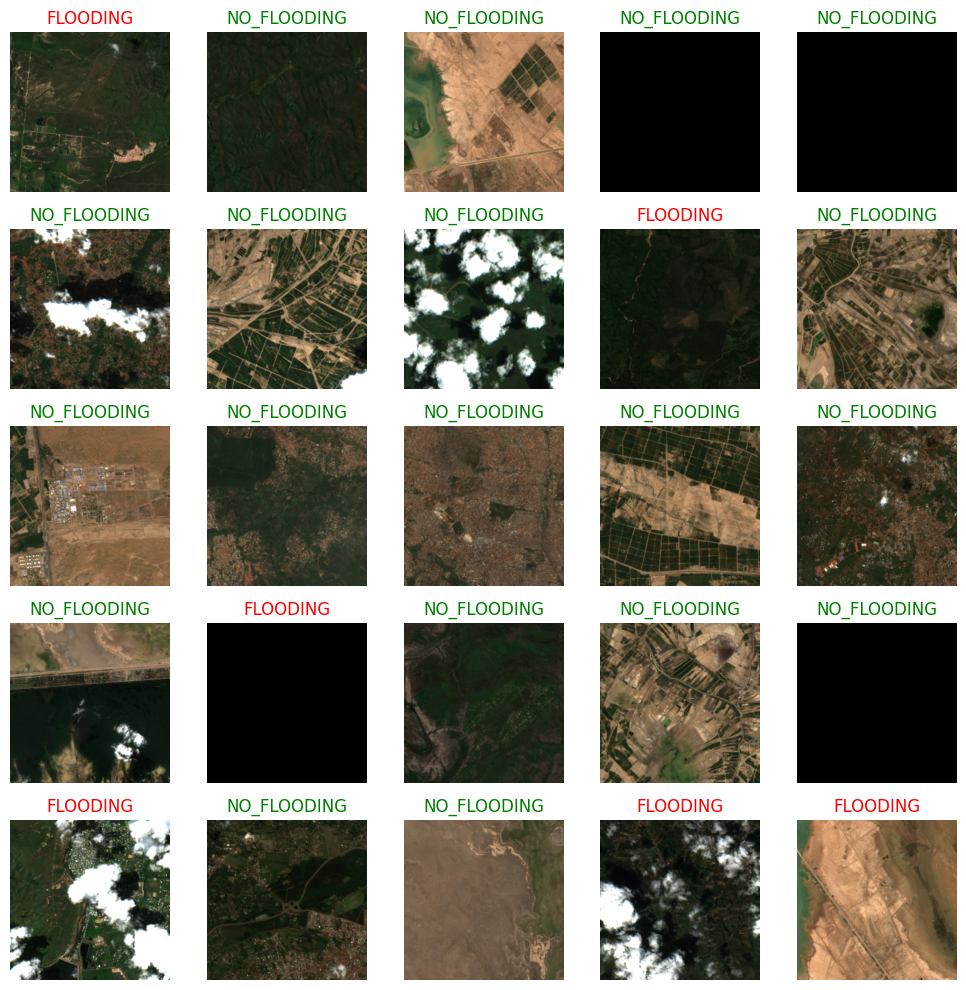

In [30]:
import matplotlib.pyplot as plt

# extract batch from test dataloader

batch = next(iter(ds.test_dataloader(shuffle=True, batch_size=25)))
imgs, labels = batch['image'], batch['label']

# compute predictions

preds = task.predict(batch)
preds = torch.argmax(preds, axis=1)

# visualize predictions

fig = plt.figure(figsize=(10, 10))
for i, (img, label, pred) in enumerate(zip(imgs, labels, preds)):
	ax = plt.subplot(5, 5, i + 1)
	ax.imshow(img.permute(1,2,0))
	gt = ds.classes[label.item()]
	pred = ds.classes[pred.item()]
	ax.set_title(gt, color="green" if gt == pred else 'red')
	ax.axis('off')
plt.tight_layout()
plt.show()